In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from setup.univ_setup import *
from setup.utils import *
from factor_mining.factors.momentum import momentum
from factor_mining.factor_preprocessing import *

In [58]:
### universe setup ###
datadir = '/home/derek-qi/Documents/R3000_Data/data/r3000/'
univ = univ_setup(datadir, silent=False)
filt_na(univ)
filt_byval(univ, 'in_r3000', 0)
filt_byval(univ, 'price', 10)
filt_byval(univ, 'not_in_MA', 0)
filt_byval(univ, 'volume', 1500000)
import warnings
warnings.filterwarnings("ignore")

Setup R3000 universe
use existing binary file
0.424778 seconds


In [59]:
%%time
from itertools import product
### calculate a batch of momentums
allShort = [4]
allLong = [13, 26, 39, 52, 65, 78, 104]
allParams = product(allShort, allLong)

allmmt = None
for short, long in allParams:
    print(short, long)
    mmt = momentum(univ, short, long, naming='full')
    if not allmmt:
        allmmt = mmt
    else:
        allmmt = merge(allmmt, mmt, right_cols=['momentum_%s_%s' % (short, long)])

4 13
4 26
4 39
4 52
4 65
4 78
4 104
CPU times: user 28 s, sys: 8 ms, total: 28 s
Wall time: 28 s


In [60]:
filt_na(allmmt)
allmmt = merge(allmmt, univ, right_cols=['f_log_ret_1'])

In [61]:
mmttb = stack(allmmt)

In [62]:
cut = int(2/3 * mmttb.shape[0])
dataIS = mmttb.iloc[:cut,:]
dataOS = mmttb.iloc[cut:,:]

In [63]:
from sklearn.linear_model import lasso_path
from sklearn.preprocessing import StandardScaler

In [72]:
xnames = ['momentum_%s_%s' % (short, long) for short, long in product(allShort, allLong)]
xscaler, yscaler = StandardScaler(), StandardScaler()
XIS = np.asarray(dataIS[xnames])
XIS_scaled = xscaler.fit_transform(XIS)
yIS = np.asarray(dataIS['f_log_ret_1'])
yIS_scaled = yscaler.fit_transform(yIS)
alpha, coefs, _ = lasso_path(XIS_scaled, yIS_scaled)

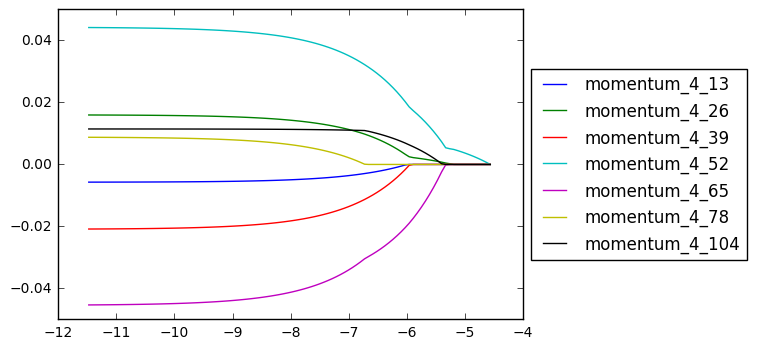

In [73]:
%matplotlib inline
for i in range(len(xnames)):
    plt.plot(np.log(alpha), coefs[i,:], label=xnames[i])
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.show()

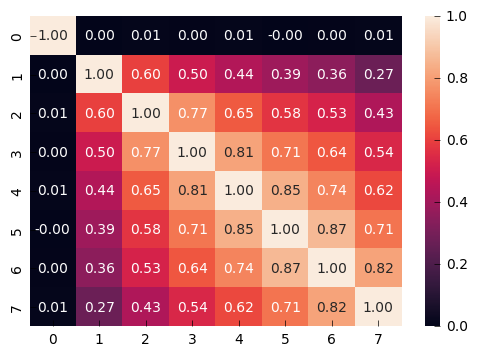

In [71]:
import seaborn as sns
cm = np.corrcoef(np.hstack([yIS.reshape(-1, 1), XIS]), rowvar=0)
sns.heatmap(cm, annot=True, fmt='.2f')

In [74]:
XOS = np.asarray(dataOS[xnames])
XOS_scaled = xscaler.fit_transform(XOS)
yOS = np.asarray(dataOS['f_log_ret_1'])
yOS_scaled = yscaler.fit_transform(yOS)
alpha, coefs, _ = lasso_path(XOS_scaled, yOS_scaled)

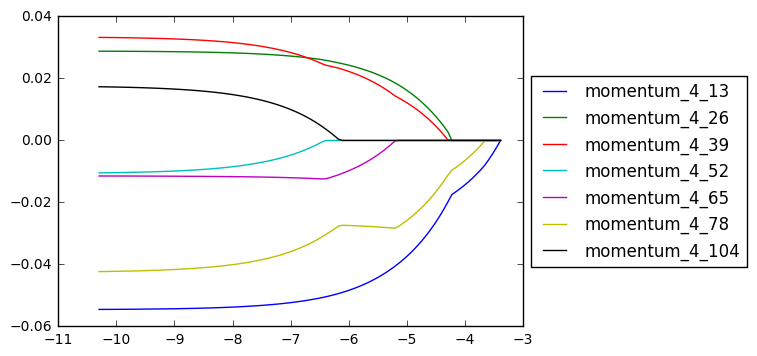

In [75]:
%matplotlib inline
for i in range(len(xnames)):
    plt.plot(np.log(alpha), coefs[i,:], label=xnames[i])
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.show()

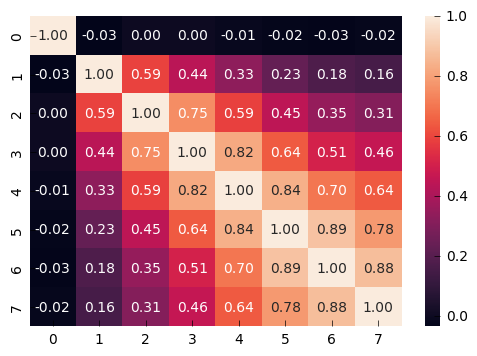

In [76]:
cm = np.corrcoef(np.hstack([yOS.reshape(-1, 1), XOS]), rowvar=0)
sns.heatmap(cm, annot=True, fmt='.2f')